### Source: https://www.kaggle.com/datasets/orvile/annotated-ultrasound-liver-images-dataset/data

In [1]:
import numpy as np
from PIL import Image
import os, json, cv2

In [2]:
data_path = os.path.join(os.getcwd(), 'Data/Annotated Ultrasound Liver images Dataset/7272660')
print(os.listdir(data_path))

['Benign', 'Malignant', 'Normal']


In [3]:
category = os.listdir(data_path)

def load_image_and_mask(image_name, image_dir, segmentation_dir):
    classes_name = ["outline", 'liver', 'mass']

    image = Image.open(os.path.join(image_dir, image_name))
    width, height = image.size
    image = np.array(image)

    mask = np.zeros((height, width), dtype=np.uint8)

    name = image_name.split('.')[0]

    for i, n in enumerate(classes_name):
        json_path = os.path.join(segmentation_dir, n, name+'.json')

        with open(json_path, 'r') as f:
            polygon = json.load(f)

        polygon = [[int(x), int(y)] for x, y in polygon]
        polygon = np.array([polygon], dtype=np.int32)

        cv2.fillPoly(mask, polygon, int(i+1))

    return image, mask

In [4]:
import tensorflow as tf

In [5]:
def create_tf_dataset(image_names, image_dir, segmentation_dir):
    def generator():
        for image_name in image_names:
            yield load_image_and_mask(image_name, image_dir, segmentation_dir)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),  # Image
            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)       # Mask
        )
    )

In [6]:
def preprocess(image, mask):
    # Resizing
    image = tf.image.resize(image, (256, 256))

    # Adding a channel size to a mask
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256, 256))

    # Normalization
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.uint8) # no normalization because masks are binary
    mask = tf.squeeze(mask, axis=-1)  # shape: (256, 256)
    mask = tf.one_hot(mask, depth=4)  # shape: (256, 256, 4)
    mask = tf.cast(mask, tf.float32)


    return image, mask

## Benign

In [7]:
from sklearn.model_selection import train_test_split

Benign_path = os.path.join(data_path, category[0], category[0])

image_dir = os.path.join(Benign_path, 'image')
segmentation_dir = os.path.join(Benign_path, 'segmentation')

image_names = os.listdir(image_dir)
print(image_names)

['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '11.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '12.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '13.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '14.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '15.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '16.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '17.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '175.jpg', '176.jpg', '177.jpg', '178.jpg', '179.jpg', '18.jpg', '180.jpg', '181.jpg'

In [8]:
train_names, val_names = train_test_split(image_names, test_size=0.2, random_state=42)
print(len(train_names), len(val_names))

160 40


In [9]:
train_dataset = create_tf_dataset(train_names, image_dir, segmentation_dir)
val_dataset = create_tf_dataset(val_names, image_dir, segmentation_dir)

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

In [10]:
for image, mask in train_dataset:
    print(image.shape)
    print(mask.shape)
    print(np.array(mask).squeeze().shape)
    print(mask)
    print(np.unique(mask))
    break

(256, 256, 3)
(256, 256, 4)
(256, 256, 4)
tf.Tensor(
[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 ...

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]], shape=(256, 256, 4), dtype=float32)
[0. 1.]


In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [12]:
def visualize_dataset(dataset, num_samples=5):
    # Select a specific number of sample images and masks from the dataset
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.figure(figsize=(10, 5))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")

        colors = ['black', 'white', 'red', 'green'] # ["outline", 'liver', 'mass']
        cmap = mcolors.ListedColormap(colors)
        # Show mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
        plt.title("Mask")
        plt.axis("off")

        plt.show()

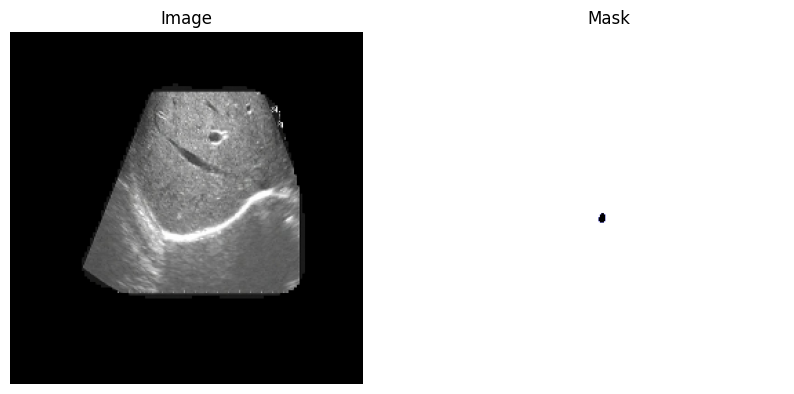

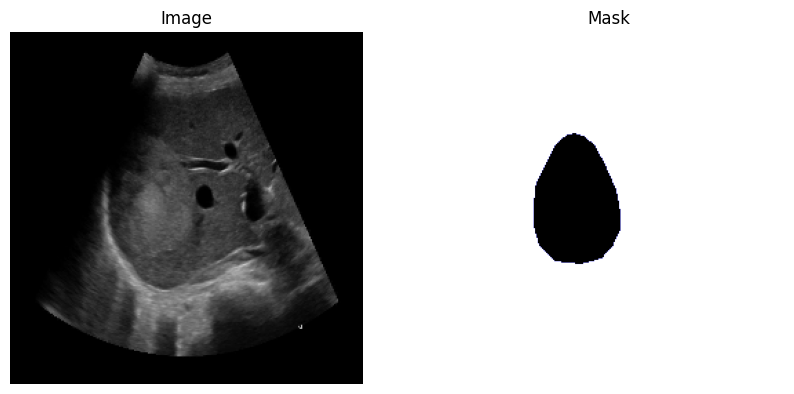

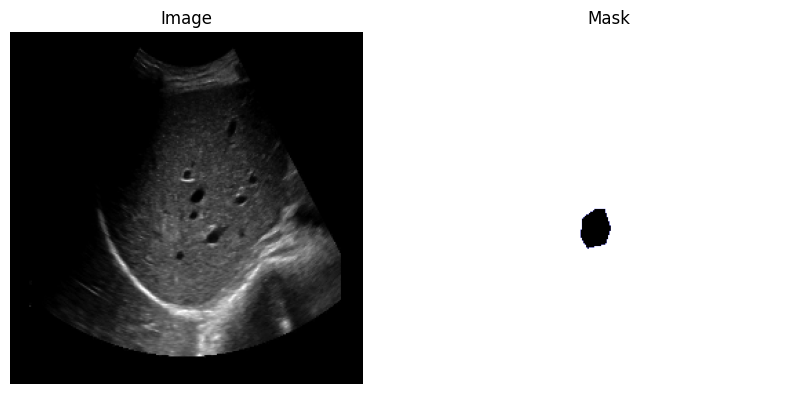

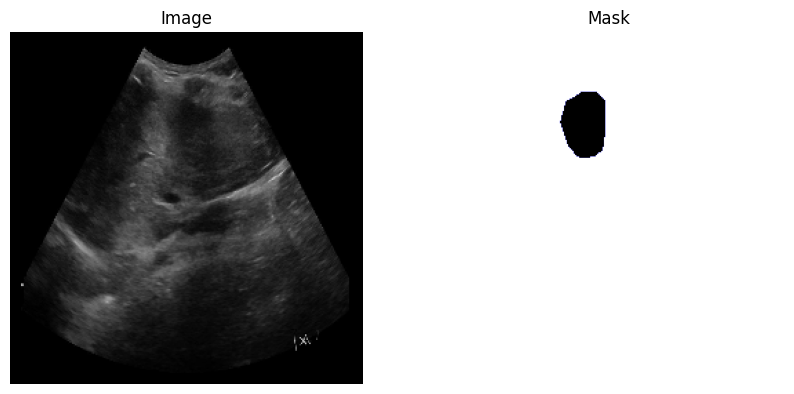

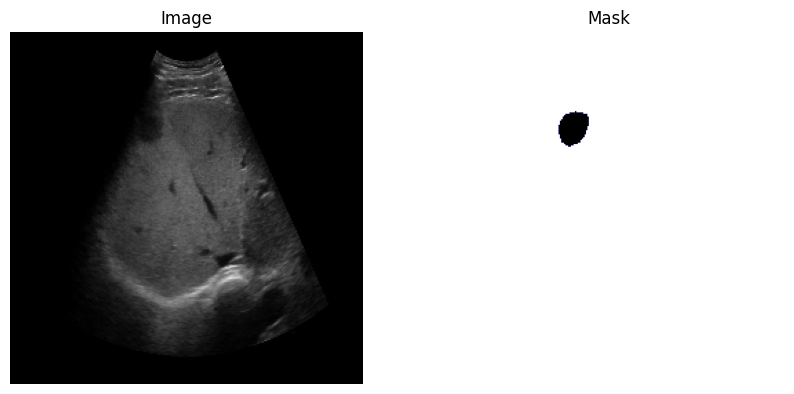

In [13]:
visualize_dataset(train_dataset)

In [14]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
def downsampling_block(inputs, n_filters, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block.

    Args:
        inputs: Input tensor.
        n_filters: Number of filters for convolutional layers.
        dropout_prob: Dropout probability.
        max_pooling: Whether to apply max pooling.

    Returns:
        next_layer: Output tensor for the next layer.
        skip_connection: Skip connection tensor.
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    next_layer = MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv
    return next_layer, conv

In [16]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Convolutional upsampling block.

    Args:
        expansive_input: Input tensor from previous layer.
        contractive_input: Skip connection tensor from encoding path.
        n_filters: Number of filters for convolutional layers.

    Returns:
        Output tensor after upsampling and convolution.
    """
    up = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [17]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=4):
    """
    U-Net model implementation.

    Args:
        input_size: Shape of the input tensor.
        n_filters: Number of filters for the convolutional layers.
        n_classes: Number of output classes.

    Returns:
        U-Net model.
    """
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    dblock1 = downsampling_block(inputs, n_filters)
    dblock2 = downsampling_block(dblock1[0], n_filters * 2)
    dblock3 = downsampling_block(dblock2[0], n_filters * 4)
    dblock4 = downsampling_block(dblock3[0], n_filters * 8)
    dblock5 = downsampling_block(dblock4[0], n_filters * 16)
    #Bottleneck
    bblock6 = downsampling_block(dblock5[0], n_filters * 32, dropout_prob=0.4, max_pooling=False)

    # Expanding Path (Decoder)
    ublock7 = upsampling_block(bblock6[0], dblock5[1], n_filters * 16)
    ublock8 = upsampling_block(ublock7, dblock4[1], n_filters * 8)
    ublock9 = upsampling_block(ublock8, dblock3[1], n_filters * 4)
    ublock10 = upsampling_block(ublock9, dblock2[1], n_filters * 2)
    ublock11 = upsampling_block(ublock10, dblock1[1], n_filters)

    # Output Layer
    conv12 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock11)
    outputs = Conv2D(n_classes, 1, activation="softmax", padding="same")(conv12)

    return Model(inputs=inputs, outputs=outputs)

In [18]:
from tensorflow.keras import backend as K

In [19]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    # Assume y_true and y_pred are both one-hot encoded
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    # One-hot y_true if it's sparse
    if y_true.shape[-1] != y_pred.shape[-1]:
        y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])

    dice = dice_loss(y_true, y_pred)
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * cce



# 🎯 Multiclass Dice Loss
def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Per class Dice loss (batch-wise)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)

    # Mean over classes and batch
    return 1 - tf.reduce_mean(dice)

# 🎯 Categorical Focal Loss (weighted)
def categorical_focal_loss(alpha, gamma=2.0):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

        # Compute softmax cross entropy with focal adjustment
        loss = -y_true * tf.math.log(y_pred)
        loss *= alpha * tf.pow(1 - y_pred, gamma)

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))  # sum over classes
    return loss

# 🎯 Combined Loss: Dice + Focal
def combined_dice_focal_loss(alpha=[1.0, 1.0, 1.0, 5.0], gamma=2.0):
    focal = categorical_focal_loss(alpha=alpha, gamma=gamma)
    def loss(y_true, y_pred):
        d_loss = dice_loss_multiclass(y_true, y_pred)
        f_loss = focal(y_true, y_pred)
        return 0.5 * d_loss + 0.5 * f_loss
    return loss

In [20]:
from tensorflow.keras.metrics import MeanIoU
miou = MeanIoU(num_classes=4)

model = unet_model(n_filters=32)


metrics = ["accuracy", dice_coef, miou]

initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_4[

 Total params: 34,595,684 (131.97 MB)

 Trainable params: 34,595,684 (131.97 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Optimizing datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = 160 // BATCH_SIZE
validation_steps = 40 // BATCH_SIZE


In [23]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [24]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.3806 - dice_coef: 0.2480 - loss: 1.0185 - mean_io_u: 0.3750 - val_accuracy: 0.6234 - val_dice_coef: 0.2581 - val_loss: 0.9917 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.6285 - dice_coef: 0.2642 - loss: 0.9794 - mean_io_u: 0.3750 - val_accuracy: 0.4768 - val_dice_coef: 0.2869 - val_loss: 0.9409 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.5726 - dice_coef: 0.3671 - loss: 0.8356 - mean_io_u: 0.3751 - val_accuracy: 0.7283 - val_dice_coef: 0.6513 - val_loss: 0.4826 - val_mean_io_u: 0.3896 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.7591 - dice_coef: 0.7019 - loss: 0.4159 - mean_io_u: 0.4497 - val_accuracy: 0.7749 - val_dice_coef: 0.7222 - val_loss: 0.3711 - val_mean_io_u: 0.4926 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━

In [25]:
test_loss, test_accuracy, test_coef, miou = model.evaluate(val_dataset, steps=validation_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}, Mean IOU: {miou}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9234 - dice_coef: 0.9076 - loss: 0.1484 - mean_io_u: 0.6039
Test Loss: 0.15467801690101624, Test Accuracy: 0.921912670135498, Test Dice Coefficient: 0.9061007499694824, Mean IOU: 0.6022235155105591


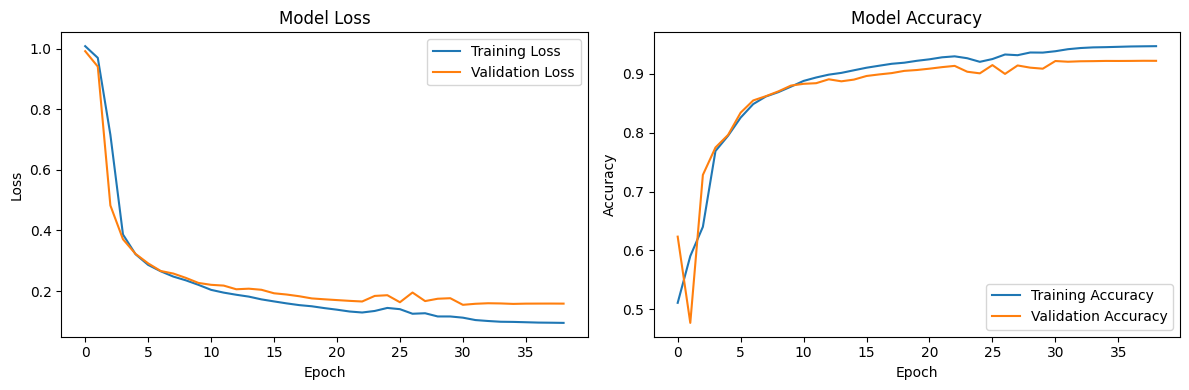

In [26]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss graph
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy graph
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [27]:
from tensorflow.keras.models import load_model
# model = load_model('best.h5')

In [37]:
import random
def visualize_predictions_multiclass(model, dataset, num_samples=5):
    # یک batch تصادفی انتخاب کن
    batch = next(iter(dataset))
    images, masks = batch  # masks shape: (batch, H, W, C)

    # انتخاب تصاویر تصادفی برای نمایش
    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    # پیش‌بینی مدل
    predictions = model.predict(images)

    print(predictions.shape)
    print(predictions[0, 0, 0])


    # گرفتن class prediction با argmax
    predicted_classes = np.argmax(predictions, axis=-1)  # shape: (batch, H, W)
    true_classes = np.argmax(masks.numpy(), axis=-1)     # shape: (batch, H, W)

    print(np.sum(predicted_classes == 3))

    for i in indices:
        plt.figure(figsize=(15, 5))

        # تصویر اصلی
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        colors = ['black', 'white', 'red', 'green'] # ["outline", 'liver', 'mass']
        cmap = mcolors.ListedColormap(colors)
        # ماسک واقعی
        plt.subplot(1, 3, 2)
        plt.imshow(true_classes[i], cmap=cmap, vmin=0, vmax=predictions.shape[-1]-1)
        plt.title('True Mask')
        plt.axis('off')
        print(np.unique(true_classes[i]))

        # ماسک پیش‌بینی‌شده
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_classes[i], cmap=cmap, vmin=0, vmax=predictions.shape[-1]-1)
        plt.title('Predicted Mask')
        plt.axis('off')
        print(np.unique(predicted_classes[i]))

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(16, 256, 256, 4)
[0.42749727 0.1157432  0.37112886 0.08563064]
0
[0 1 2 3]
[0 1 2]


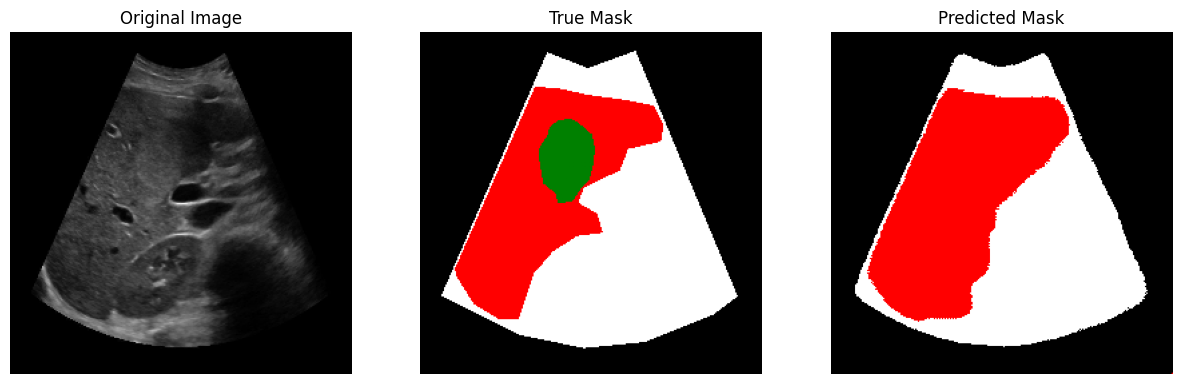

[0 1 2 3]
[0 1 2]


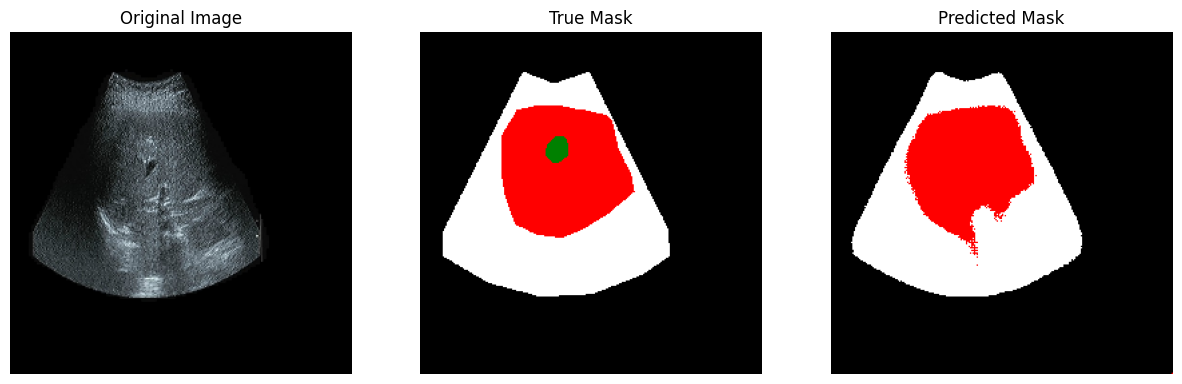

[0 1 2 3]
[0 1 2]


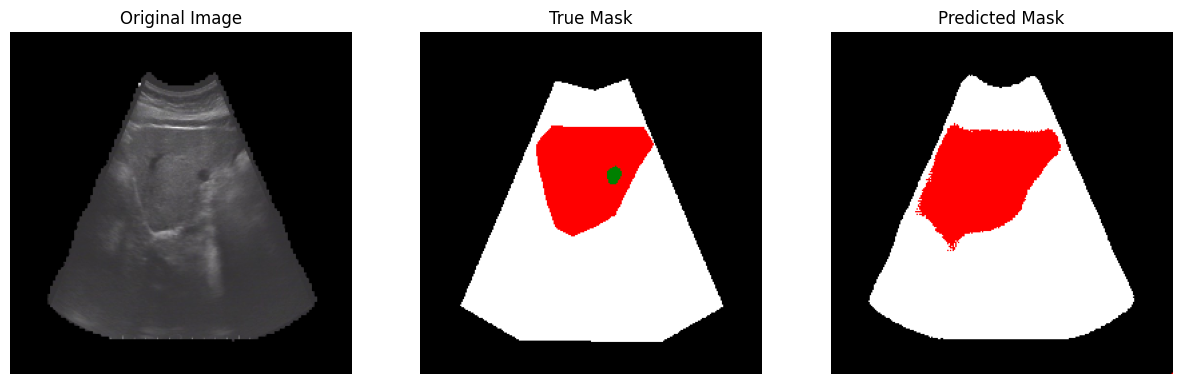

[0 1 2 3]
[0 1 2]


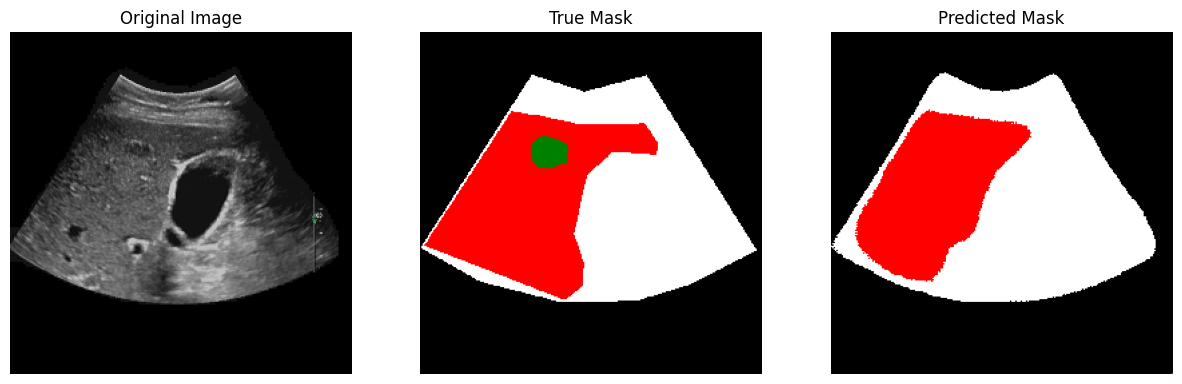

[0 1 2 3]
[0 1 2]


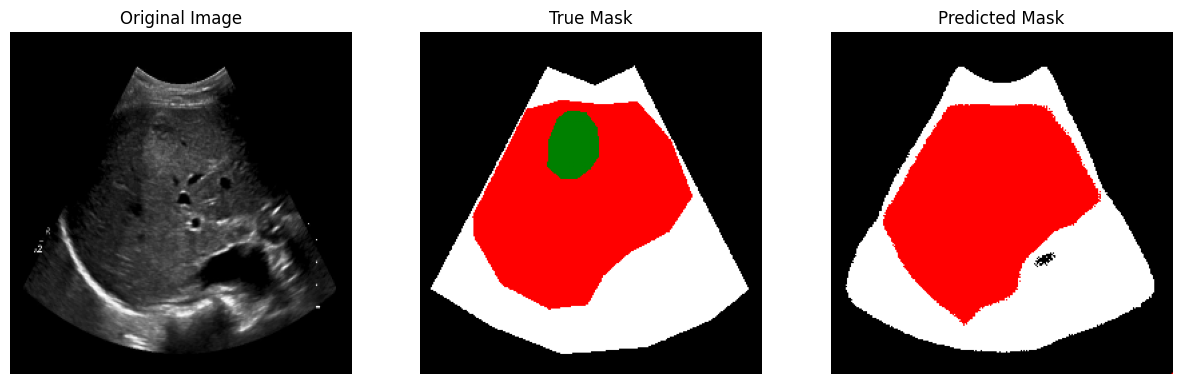

In [38]:
visualize_predictions_multiclass(model, val_dataset)